[*********************100%***********************]  1 of 1 completed

Sharpe: 0.79, Max Drawdown: 13.21%


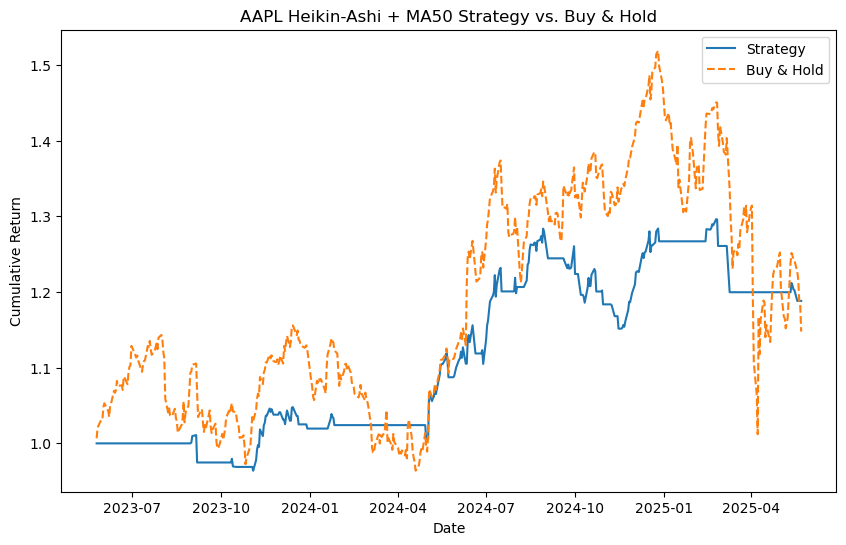

In [84]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Set up parameters
ticker   = "AAPL"    # ticker symbol to back-test
period   = "2y"      # lookback period of two years
interval = "1d"      # daily price data

# 2. Download price data and flatten column MultiIndex if present
df = yf.download(ticker, period=period, interval=interval)
if isinstance(df.columns, pd.MultiIndex):
    # keep only the first level (Open, High, Low, Close, Volume)
    df.columns = df.columns.get_level_values(0)
df.dropna(inplace=True)  # remove any rows with missing values

# 3. Compute Heikin-Ashi candles
# 3.1 HA_Close is the average of the four standard prices
df['HA_Close'] = df[['Open','High','Low','Close']].mean(axis=1)

# 3.2 Initialize HA_Open using the midpoint of the first bar
first_ha_open = (df['Open'].values[0] + df['Close'].values[0]) / 2
ha_open = [first_ha_open]
# 3.3 Iteratively compute subsequent HA_Open values
for prev_close in df['HA_Close'].values[:-1]:
    ha_open.append((ha_open[-1] + prev_close) / 2)
df['HA_Open'] = ha_open

# 3.4 HA_High and HA_Low use the extremes of original High/Low and HA_Open/HA_Close
df['HA_High'] = df[['High','HA_Open','HA_Close']].max(axis=1)
df['HA_Low']  = df[['Low','HA_Open','HA_Close']].min(axis=1)

# 4. Calculate the 50-day simple moving average for trend filtering
df['MA50'] = df['Close'].rolling(window=50).mean()

# 5. Generate trading signal (long=1, flat=0)
#    Only go long when HA_Close > HA_Open AND Close > MA50
mask    = (df['HA_Close'].values > df['HA_Open'].values) & \
          (df['Close'].values.ravel() > df['MA50'].values)
signals = mask.astype(int)
df['Signal']   = signals
df['Position'] = df['Signal']  # shift to use next-day returns if desired

# 6. Backtest and compute performance metrics
df['Return'] = df['Close'].pct_change() * df['Position'].shift()
cumret      = (1 + df['Return']).cumprod()                    # cumulative return series
sharpe      = df['Return'].mean() / df['Return'].std() * np.sqrt(252)  # annualized Sharpe
mdd         = (cumret.cummax() - cumret).max()                # maximum drawdown

print(f"Sharpe: {sharpe:.2f}, Max Drawdown: {mdd:.2%}")

# 7. Plot strategy vs. buy-and-hold
plt.figure(figsize=(10,6))
plt.plot(cumret, label='Strategy')
plt.plot((1 + df['Close'].pct_change()).cumprod(),
         '--', label='Buy & Hold')
plt.title(f"{ticker} Heikin-Ashi + MA50 Strategy vs. Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()
